### MNIST_dataを用意

In [1]:
import numpy as np
import pandas as pd

In [16]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [17]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8

(60000, 28, 28)
(10000, 28, 28)
uint8


In [18]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [19]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


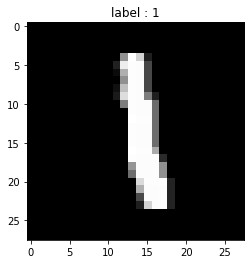

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 6
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

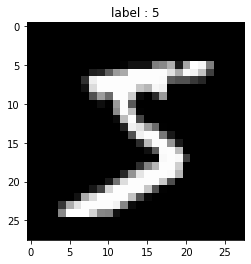

In [21]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

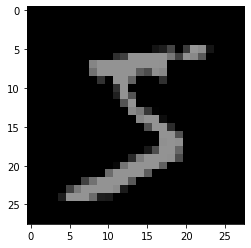

In [22]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

In [23]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [24]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


## 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。

In [27]:
np.random.seed(seed=32)
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)

In [58]:
W1.shape

(784, 400)

In [29]:
np.random.seed(seed=32)
n_nodes1 = 400
sigma = 0.01
B1 = sigma * np.random.randn(n_nodes1)

In [30]:
B1.shape

(400,)

In [31]:
np.random.seed(seed=32)
n_nodes1 = 400
n_nodes2 = 200
sigma = 0.01
W2 = sigma * np.random.randn(n_nodes1, n_nodes2 )
# W2: (400, 200)

In [32]:
W2.shape

(400, 200)

In [33]:
np.random.seed(seed=32)
n_nodes2 = 200
sigma = 0.01
B2 = sigma * np.random.randn(n_nodes2)

In [34]:
B2.shape

(200,)

In [35]:
np.random.seed(seed=32)
n_nodes2 = 200
n_nodes3 = 10
sigma = 0.01
W3 = sigma * np.random.randn(n_nodes2, n_nodes3)
# W3: (784, 10)

In [36]:
W3.shape

(200, 10)

In [37]:
np.random.seed(seed=32)
n_nodes3 = 10
sigma = 0.01
B3 = sigma * np.random.randn(n_nodes3)

In [38]:
B3.shape

(10,)

## 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。

batch_size = 20 # バッチサイズ  
n_features = 784 # 特徴量の数  
n_nodes1 = 400 # 1層目のノード数  
n_nodes2 = 200 # 2層目のノード数  
n_output = 10 # 出力のクラス数（3層目のノード数）

In [39]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [40]:
len(X_train)/20

2400.0

f
(
Z
)
=
s
i
g
m
o
i
d
(
A
)
=
1/
1
+
e
x
p
(
−
A
)


In [41]:
def sigmoid_function(X):
    return 1/(1+np.exp(-X))

f
(
Z
)
=
t
a
n
h
(
A
)
=
e
x
p
(
A
)
−
e
x
p
(
−
A
)/
e
x
p
(
A
)
+
e
x
p
(
−
A
)

In [42]:
def hyper_tan_function(X):
    return np.tanh(X)

Z
3
_
k
=
e
x
p
(
A
3
_
k
)/
∑
(n
c, 
i
=
1)
e
x
p
(
A
3
_
i
)


In [43]:
def soft_max_function(X):
    return np.exp(X)/(np.exp(X).sum(1).reshape(-1, 1))

A
1
=
X
⋅
W
1
+
B
1
 


In [59]:
mini_X_train = X_train[:20]
mini_X_train.shape

(20, 784)

In [63]:
W1.shape

(784, 400)

In [64]:
A1 = np.dot(mini_X_train, W1) + B1

In [65]:
A1.shape

(20, 400)

Z
1
=
f
(
A
1
)

In [66]:
Z1 = sigmoid_function(A1)

In [67]:
Z1.shape

(20, 400)

A
2
=
Z
1
⋅
W
2
+
B
2

In [68]:
A2 = np.dot(Z1, W2) + B2

In [69]:
A2.shape

(20, 200)

Z
2
=
f
(
A
2
)

In [70]:
Z2 = sigmoid_function(A2)

In [71]:
Z2.shape

(20, 200)

A
3
=
Z
2
⋅
W
3
+
B
3

In [72]:
A3 = np.dot(Z2, W3) + B3

In [73]:
A3.shape

(20, 10)

Z
3
=
s
o
f
t
m
a
x
(
A
3
)

In [76]:
Z3 = soft_max_function(A3)

In [77]:
Z3.shape

(20, 10)

In [78]:
Z3.argmax(1).shape

(20,)

In [79]:
Z3.sum(1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

## 【問題3】交差エントロピー誤差の実装
目的関数（損失関数）を作成します。


多クラス分類の目的関数である交差エントロピー誤差 
L
 は次の数式です。

L
=
−
1
n
b
n
b
∑
j  
n
c
∑
k
y
j
k
l
o
g
(
z
3
_
j
k
)

(48000, 10)

In [82]:
mini_y_train = y_train[:20]
mini_y_train.shape

(20, 10)

In [83]:
batch_size = 20
L = -mini_y_train*(np.log(Z3))/batch_size

In [84]:
L.sum()

2.2847132066650833

In [85]:
X_train.shape[0]

48000

In [86]:
def cross_entropy_loss(Z,y):
    batch_size = 20
    
    l =  -y*(np.log(Z))/batch_size
    L = l.sum()
    return L

## 【問題4】バックプロパゲーションの実装
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。

## DLDB3 =

In [87]:
B3.shape

(10,)

In [89]:
DLDB3 = (Z3 - mini_y_train).sum(0)
DLDB3.shape

(10,)

## DLDW3 =

In [90]:
W3.shape

(200, 10)

In [91]:
DLDW3 = np.dot(Z2.T, (Z3 - mini_y_train))
DLDW3.shape

(200, 10)

## DLDB2 = 

In [92]:
B2.shape

(200,)

In [93]:
sig_B2 = (1 - sigmoid_function(A2))*sigmoid_function(A2)
sig_B2.shape

(20, 200)

In [94]:
W3.T.shape

(10, 200)

In [95]:
(Z3 - mini_y_train).shape

(20, 10)

In [96]:
left_B2 =  np.dot((Z3 - mini_y_train), W3.T)
left_B2.shape

(20, 200)

In [98]:
DLDB2 = ((left_B2)*sig_B2).sum(0)
DLDB2.shape

(200,)

## DLDW2 = 

In [99]:
W2.shape

(400, 200)

In [100]:
W3.T.shape

(10, 200)

In [101]:
(Z3 - mini_y_train).shape

(20, 10)

In [102]:
W2_left_1 = np.dot((Z3 - mini_y_train), W3.T)
W2_left_1.shape

(20, 200)

In [103]:
sig_W2_right = (1 - sigmoid_function(A2))*sigmoid_function(A2)
sig_W2_right.shape

(20, 200)

In [104]:
sig_W2 = (W2_left_1*sig_W2_right)
sig_W2.shape

(20, 200)

In [105]:
Z1.T.shape

(400, 20)

In [106]:
DLDW2 = np.dot(Z1.T, sig_W2)
DLDW2.shape

(400, 200)

## DLDB1 =

In [107]:
B1.shape

(400,)

In [108]:
DLDB2.shape

(200,)

In [109]:
W2.T.shape

(200, 400)

In [110]:
sig_B1 = (1 - sigmoid_function(A1))*sigmoid_function(A1)
sig_B1.sum(0).shape

(400,)

In [111]:
left_B1 = np.dot(DLDB2, W2.T)
left_B1.shape

(400,)

In [112]:
DLDB1 = left_B1*sig_B1.sum(0)
DLDB1.shape

(400,)

## DLDW1 = 

In [113]:
W1.shape

(784, 400)

In [114]:
sig_W2.shape

(20, 200)

In [115]:
sig_W1 = (1 - sigmoid_function(A1))*sigmoid_function(A1)
sig_W1.shape

(20, 400)

In [116]:
W2.T.shape

(200, 400)

In [117]:
center_W1 = np.dot(sig_W2, W2.T)
center_W1.shape

(20, 400)

In [118]:
right_W1 = center_W1*sig_W1
right_W1.shape

(20, 400)

In [121]:
mini_y_train.T.shape

(10, 20)

In [122]:
DLDW1 = np.dot(mini_y_train.T, right_W1)
DLDW1.shape

(10, 400)

In [124]:
delta1 = Z3 - mini_y_train
delta2 = ((1 - sigmoid_function(A2))*sigmoid_function(A2))*np.dot(delta1, W3.T)
delta3 = ((1 - sigmoid_function(A1))*sigmoid_function(A1))*np.dot(delta2, W2.T)
print(delta1.shape, delta2.shape, delta3.shape)

(20, 10) (20, 200) (20, 400)


In [125]:
# ３層目
DLDB3 = delta1.sum(0)
DLDW3 = np.dot(Z2.T, delta1)
# ２層目
DLDB2 = delta2.sum(0)
DLDW2 = np.dot(Z1.T, delta2)
# １層目
DLDB1 = delta3.sum(0)
DLDW1 = np.dot(mini_X_train.T, delta3)

print(DLDB3.shape, DLDW3.shape)
print(DLDB2.shape, DLDW2.shape)
print(DLDB1.shape, DLDW1.shape)

print(B3.shape, W3.shape)
print(B2.shape, W2.shape)
print(B1.shape, W1.shape)


(10,) (200, 10)
(200,) (400, 200)
(400,) (784, 400)
(10,) (200, 10)
(200,) (400, 200)
(400,) (784, 400)


## 【問題5】推定
推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

## 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。

## 【問題7】学習曲線のプロット
学習曲線をプロットしてください。

## 【問題8】（アドバンス課題）誤分類の確認
誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください

In [126]:
from sklearn.metrics import accuracy_score

In [130]:
class ScratchSimpleNeuralNetrowkClassifier():
        
        """
        シンプルな三層ニューラルネットワーク分類器

        Parameters
        ----------

        Attributes
        ----------
        """
        def __init__(self, verbose = True, epoch = 0):
            self.verbose = verbose
            self.n_features = 784
            self.n_nodes1 = 400
            self.n_nodes2 = 200
            self.n_nodes3 = 10
            self.sigma = 0.01   # ガウス分布の標準偏差
            self.batch_size=20
            self.loss_box = []
            self.W1 = 0
            self.B1 = 0
            self.W2 = 0
            self.B2 = 0
            self.W3 = 0
            self.B3 = 0
            self.epoch = epoch
            pass
    
        def fit(self, X, y, X_val=None, y_val=None):
            """
            ニューラルネットワーク分類器を学習する。

            Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
                訓練データの特徴量
            y : 次の形のndarray, shape (n_samples, )
                訓練データの正解値
            X_val : 次の形のndarray, shape (n_samples, n_features)
                検証データの特徴量
            y_val : 次の形のndarray, shape (n_samples, )
                検証データの正解値
            """

            """
            初期値
            """
            np.random.seed(seed=32)
            self.W1 = sigma * np.random.randn(self.n_features, self.n_nodes1)
            self.B1 = sigma * np.random.randn(self.n_nodes1)
            self.W2 = sigma * np.random.randn(self.n_nodes1, self.n_nodes2 )
            self.B2 = sigma * np.random.randn(self.n_nodes2)
            self.W3 = sigma * np.random.randn(self.n_nodes2, self.n_nodes3)
            self.B3 = sigma * np.random.randn(self.n_nodes3)
            
#             """全バッチのZ3"""間違え
#             self.all_Z3 = np.ones([X_train.shape[0],10])
#             count = 0

            """エポック回イテレート"""
            for i in range(self.epoch):
                """Get_mini_batch"""
                get_mini_batch = GetMiniBatch(X, y, batch_size=20)

                for mini_X_train, mini_y_train in get_mini_batch:
#                     print(mini_y_train.shape)

                    """
                    Forword
                    """
                    A1 = np.dot(mini_X_train, self.W1) + self.B1
                    Z1 = self.sigmoid_function(A1)
                    A2 = np.dot(Z1, self.W2) + self.B2
                    Z2 = self.sigmoid_function(A2)
                    A3 = np.dot(Z2, self.W3) + self.B3
                    Z3 = self.soft_max_function(A3)
                    
#                     """Z3 書き換え ＊間違え"""
# #                     self.all_Z3[(0+count*20):(20+count*20), :] = self.Z3
# #                     count += 1


                    """
                    Backword
                    """
                    # dL/dA1
                    delta1 = Z3 - mini_y_train
                    delta2 = (1 - self.hyper_tan_function(A2)**2)*np.dot(delta1, self.W3.T)
                    delta3 = (1 - self.hyper_tan_function(A1)**2)*np.dot(delta2, self.W2.T)
    
                    # ３層目
                    DLDB3 = delta1.sum(0)
                    DLDW3 = np.dot(Z2.T, delta1)
                    
                    # ２層目
                    DLDB2 = delta2.sum(0)
                    DLDW2 = np.dot(Z1.T, delta2)
                    
                    # １層目
                    DLDB1 = delta3.sum(0)
                    DLDW1 = np.dot(mini_X_train.T, delta3)

                    """
                    Gradient_Descent
                    """
                    self.B3 = self.gradient_dicent_function(self.B3, DLDB3)
                    self.W3 = self.gradient_dicent_function(self.W3, DLDW3)

                    self.B2 = self.gradient_dicent_function(self.B2, DLDB2)
                    self.W2 = self.gradient_dicent_function(self.W2, DLDW2)

                    self.B1 = self.gradient_dicent_function(self.B1, DLDB1)
                    self.W1 = self.gradient_dicent_function(self.W1, DLDW1)
                    
                    
                """
                Forword  after optimized weight
                """
                A1 = np.dot(X, self.W1) + self.B1
                Z1 = self.sigmoid_function(A1)
                A2 = np.dot(Z1, self.W2) + self.B2
                Z2 = self.sigmoid_function(A2)
                A3 = np.dot(Z2, self.W3) + self.B3
                Z3 = self.soft_max_function(A3)
                
                """
                Evaluation
                """
                print(str(i)+'_TIMES　of epoch')
                print(self.cross_entropy_loss(Z3, y))
                print(accuracy_score(y.argmax(1), Z3.argmax(1)))
                
                self.loss_box.append(self.cross_entropy_loss(Z3, y))
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                return self.loss_box

        def sigmoid_function(self, X):
            return (1/(1+np.exp(-X)))

        def hyper_tan_function(self, X):
            return np.tanh(X)

        def soft_max_function(self, X):
            return np.exp(X)/(np.exp(X).sum(1).reshape(-1, 1))

        def cross_entropy_loss(self, final_Z, y):
            l =  -y*(np.log(final_Z))/self.batch_size
            L = l.sum()
            return L

        def gradient_dicent_function(self,curent_one, delta):
            alpha = 0.01
            curent_one -= alpha*delta
            return curent_one

        def predict(self, X):
            """
            Forword action after optimized weight
            """
            A1 = np.dot(X, self.W1) + self.B1
            Z1 = self.sigmoid_function(A1)
            A2 = np.dot(Z1, self.W2) + self.B2
            Z2 = self.sigmoid_function(A2)
            A3 = np.dot(Z2, self.W3) + self.B3

            Z3 = self.soft_max_function(A3)
            
            
            return Z3.argmax(1)

In [131]:
nnc = ScratchSimpleNeuralNetrowkClassifier(epoch = 10)

In [132]:
loss_box = nnc.fit(X_train, y_train)

0_TIMES　of epoch
945.2918777112877
0.8872708333333333
1_TIMES　of epoch
457.08493952948777
0.9445
2_TIMES　of epoch
338.33868004071803
0.9585
3_TIMES　of epoch
240.57188558314698
0.9695208333333334
4_TIMES　of epoch
190.0646120101265
0.9755
5_TIMES　of epoch
147.8671696424547
0.9805416666666666
6_TIMES　of epoch
120.83741458314553
0.9838958333333333
7_TIMES　of epoch
101.37027224345607
0.9871666666666666
8_TIMES　of epoch
73.85307601329734
0.9905
9_TIMES　of epoch
58.61670885936582
0.9924375


In [133]:
y_pred = nnc.predict(X_val)

In [134]:
y_pred

array([7, 2, 3, ..., 0, 7, 8])

In [135]:
accuracy_score(y_val.argmax(1), y_pred)

0.9745

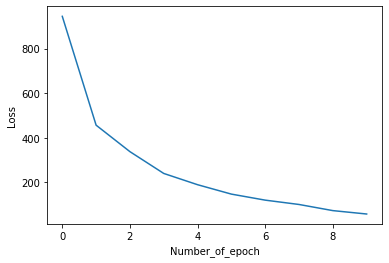

In [136]:
import matplotlib.pyplot as plt
plt.xlabel('Number_of_epoch')
plt.ylabel('Loss')
plt.plot(loss_box)
plt.show()

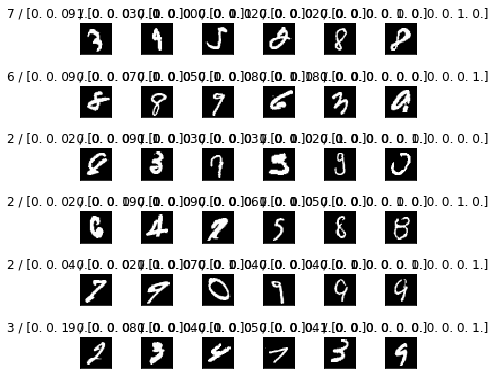

In [137]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか
true_false = y_pred==y_val.argmax(1)
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')